# Tidy Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 6
pd.options.display.max_columns = 6

Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

If there's one maxim I can impart it's that your tools shouldn't get in the way of your analysis. Your problem is already difficult enough, don't let the data or your tools make it any harder.

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We'll cover a few methods that help you get there.

In [2]:
url = "http://www.basketball-reference.com/leagues/NBA_2015_games.html"
tables = pd.read_html(url)
games = tables[0]
games.to_csv('data/games.csv', index=False)

In [3]:
!head -n 5 data/games.csv

Date,Start (ET),Unnamed: 2,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 7,Notes
October,,,,,,,,
"Tue, Oct 28, 2014",10:30 pm,Box Score,Houston Rockets,108.0,Los Angeles Lakers,90.0,,
"Tue, Oct 28, 2014",8:00 pm,Box Score,Orlando Magic,84.0,New Orleans Pelicans,101.0,,
"Tue, Oct 28, 2014",8:00 pm,Box Score,Dallas Mavericks,100.0,San Antonio Spurs,101.0,,


The Question:
> **How many days of rest did each team get between each game?**

Whether or not your dataset is tidy depends on your question. Given our question, what is an observation?

In [4]:
# parse and convert
column_names = ['date1', 'time1', '_', 'away_team', 'away_points', 
                'home_team', 'home_points', 'n_ot', 'notes']
games = (pd.read_csv('data/games.csv', names=column_names, 
                      header=None, skiprows=2)
           .assign(date=lambda x: 
                  pd.to_datetime(x['date1'] + ' ' + x['time1'], 
                                 errors='coerce'))
            .drop(['_', 'date1', 'time1', 'notes', 'n_ot'], axis='columns')
            .set_index('date', append=True)
        )
games

,,away_team,away_points,home_team,home_points
,date,,,,
0,2014-10-28 22:30:00,Houston Rockets,108.0,Los Angeles Lakers,90.0
1,2014-10-28 20:00:00,Orlando Magic,84.0,New Orleans Pelicans,101.0
2,2014-10-28 20:00:00,Dallas Mavericks,100.0,San Antonio Spurs,101.0
...,...,...,...,...,...
1233,2015-04-15 20:00:00,Detroit Pistons,112.0,New York Knicks,90.0
1234,2015-04-15 20:00:00,Miami Heat,105.0,Philadelphia 76ers,101.0
1235,2015-04-15 19:00:00,Charlotte Hornets,87.0,Toronto Raptors,92.0


In [5]:
games.index.names = ['game_id', 'date']
games       

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2014-10-28 22:30:00,Houston Rockets,108.0,Los Angeles Lakers,90.0
1,2014-10-28 20:00:00,Orlando Magic,84.0,New Orleans Pelicans,101.0
2,2014-10-28 20:00:00,Dallas Mavericks,100.0,San Antonio Spurs,101.0
...,...,...,...,...,...
1233,2015-04-15 20:00:00,Detroit Pistons,112.0,New York Knicks,90.0
1234,2015-04-15 20:00:00,Miami Heat,105.0,Philadelphia 76ers,101.0
1235,2015-04-15 19:00:00,Charlotte Hornets,87.0,Toronto Raptors,92.0


Is `games` a tidy dataset, given our question? No, we have multiple observations (teams) per row. We'll use `pd.melt` to fix that.

In [6]:
# wide to long
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], 
               value_vars=['away_team', 'home_team'],
               value_name='team')

In [7]:
tidy

,game_id,date,variable,team
0,0,2014-10-28 22:30:00,away_team,Houston Rockets
1,1,2014-10-28 20:00:00,away_team,Orlando Magic
2,2,2014-10-28 20:00:00,away_team,Dallas Mavericks
...,...,...,...,...
2469,1233,2015-04-15 20:00:00,home_team,New York Knicks
2470,1234,2015-04-15 20:00:00,home_team,Philadelphia 76ers
2471,1235,2015-04-15 19:00:00,home_team,Toronto Raptors


In [8]:
tidy[tidy.game_id==0]

,game_id,date,variable,team
0,0,2014-10-28 22:30:00,away_team,Houston Rockets
1236,0,2014-10-28 22:30:00,home_team,Los Angeles Lakers


In [9]:
# long to wide
(tidy
     .pivot(index='game_id',columns='variable')
     .reset_index()
 )

game_id                date                                   team                      
variable                   away_team           home_team          away_team             home_team
0              0 2014-10-28 22:30:00 2014-10-28 22:30:00    Houston Rockets    Los Angeles Lakers
1              1 2014-10-28 20:00:00 2014-10-28 20:00:00      Orlando Magic  New Orleans Pelicans
2              2 2014-10-28 20:00:00 2014-10-28 20:00:00   Dallas Mavericks     San Antonio Spurs
...          ...                 ...                 ...                ...                   ...
1233        1233 2015-04-15 20:00:00 2015-04-15 20:00:00    Detroit Pistons       New York Knicks
1234        1234 2015-04-15 20:00:00 2015-04-15 20:00:00         Miami Heat    Philadelphia 76ers
1235        1235 2015-04-15 19:00:00 2015-04-15 19:00:00  Charlotte Hornets       Toronto Raptors

[1236 rows x 5 columns]

Now the translation from question to operation is direct:

In [10]:
tidy

,game_id,date,variable,team
0,0,2014-10-28 22:30:00,away_team,Houston Rockets
1,1,2014-10-28 20:00:00,away_team,Orlando Magic
2,2,2014-10-28 20:00:00,away_team,Dallas Mavericks
...,...,...,...,...
2469,1233,2015-04-15 20:00:00,home_team,New York Knicks
2470,1234,2015-04-15 20:00:00,home_team,Philadelphia 76ers
2471,1235,2015-04-15 19:00:00,home_team,Toronto Raptors


In [11]:
# For each team... get number of dates between games
tidy.groupby('team')['date'].diff().dt.days - 1

0       NaN
1       NaN
2       NaN
       ... 
2469    4.0
2470    1.0
2471    9.0
dtype: float64

In [12]:
tidy.groupby('team').get_group('Los Angeles Lakers')

,game_id,date,variable,team
10,10,2014-10-29 22:00:00,away_team,Los Angeles Lakers
30,30,2014-11-01 22:30:00,away_team,Los Angeles Lakers
105,105,2014-11-11 20:00:00,away_team,Los Angeles Lakers
...,...,...,...,...
2422,1186,2015-04-10 22:30:00,home_team,Los Angeles Lakers
2439,1203,2015-04-12 21:30:00,home_team,Los Angeles Lakers
2464,1228,2015-04-15 22:30:00,home_team,Los Angeles Lakers


In [13]:
tidy.groupby('team').get_group('Los Angeles Lakers')['date'].diff()

10                 NaT
30     3 days 00:30:00
105    9 days 21:30:00
             ...      
2422   5 days 01:00:00
2439   1 days 23:00:00
2464   3 days 01:00:00
Name: date, dtype: timedelta64[ns]

In [14]:
tidy['rest'] = (tidy
                    .sort_values('date')
                    .groupby('team')
                    .date.diff()
                    .dt
                    .days - 1
)
tidy.dropna()

,game_id,date,variable,team,rest
10,10,2014-10-29 22:00:00,away_team,Los Angeles Lakers,-1.0
14,14,2014-10-29 21:00:00,away_team,Houston Rockets,-1.0
15,15,2014-10-30 20:00:00,away_team,New York Knicks,0.0
...,...,...,...,...,...
2469,1233,2015-04-15 20:00:00,home_team,New York Knicks,1.0
2470,1234,2015-04-15 20:00:00,home_team,Philadelphia 76ers,1.0
2471,1235,2015-04-15 19:00:00,home_team,Toronto Raptors,-1.0


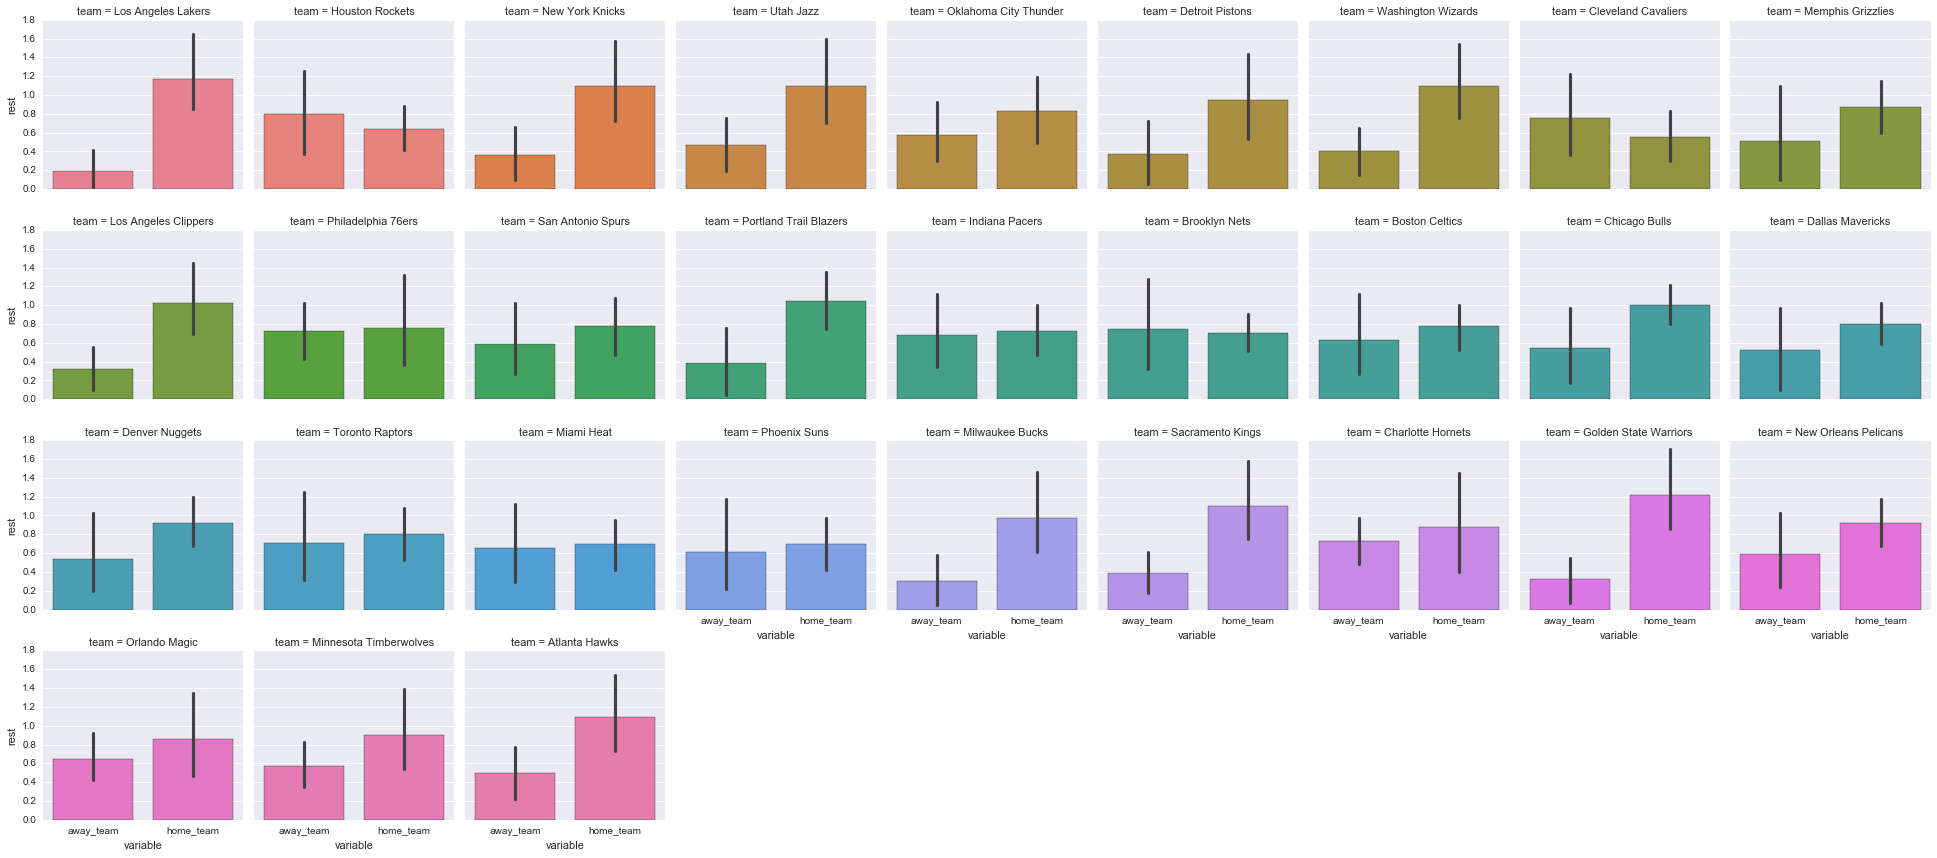

In [15]:
(tidy.dropna()
     .pipe(sns.FacetGrid, col='team', col_wrap=9, hue='team')
     .map(sns.barplot, "variable", "rest")
 )

What are we doing?

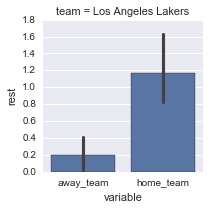

In [16]:
(tidy
     .dropna()
     .query('team == "Los Angeles Lakers"')
     .pipe(sns.FacetGrid, col='team', hue='team')
     .map(sns.barplot, "variable", "rest")
 )

In [17]:
g = (tidy
        .dropna()
        .query('team == "Los Angeles Lakers"')
        .groupby('variable')
     )
g.rest.sum()/g.rest.count()

variable
away_team    0.195122
home_team    1.175000
Name: rest, dtype: float64

# Stack / Unstack

An "observation" depends on the question. Home team advantage?

Home win percent: 0.572006472492


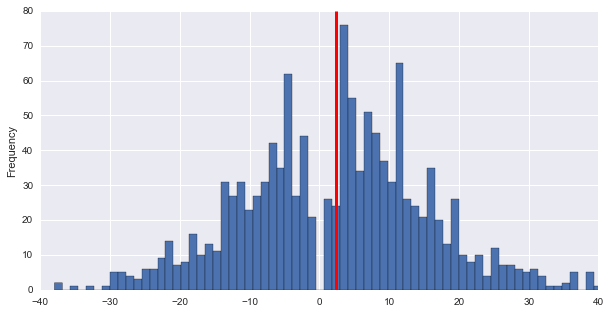

In [18]:
home_adv = games.home_points - games.away_points
ax = home_adv.plot(kind='hist', bins=80, figsize=(10, 5))
ax.set_xlim(-40, 40)
ax.vlines(home_adv.mean(), *ax.get_ylim(), color='red', linewidth=3)
print('Home win percent:', (home_adv > 0).mean())

# Team Strength

### Mini Project: Home Court Advantage?

What's the effect (in terms of probability to win) of being
the home team.


### Step 1. Calculate Win %

We need to create an indicator for whether the home team won.
Add it as a column called `home_win` in `games`.

In [19]:
games['home_win'] = games['home_points'] > games['away_points']
games

,,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,
0,2014-10-28 22:30:00,Houston Rockets,108.0,Los Angeles Lakers,90.0,False
1,2014-10-28 20:00:00,Orlando Magic,84.0,New Orleans Pelicans,101.0,True
2,2014-10-28 20:00:00,Dallas Mavericks,100.0,San Antonio Spurs,101.0,True
...,...,...,...,...,...,...
1233,2015-04-15 20:00:00,Detroit Pistons,112.0,New York Knicks,90.0,False
1234,2015-04-15 20:00:00,Miami Heat,105.0,Philadelphia 76ers,101.0,False
1235,2015-04-15 19:00:00,Charlotte Hornets,87.0,Toronto Raptors,92.0,True


### Step 2: Find the win percent for each team

Teams are split across two columns. It's easiest to calculate the number of wins and number of games as away, and the number of wins and number of games as home. Then combine those two results to get the win percent.

In [20]:
wins_as_away = games.groupby('away_team').home_win.agg(
    {'n_games': 'count', 'n_wins': lambda x: (~x).sum()}
)
wins_as_home = games.groupby('home_team').home_win.agg(
    {'n_games': 'count', 'n_wins': 'sum'}
)
wins = (wins_as_away + wins_as_home)
wins

,n_wins,n_games
away_team,,
Atlanta Hawks,60.0,82
Boston Celtics,40.0,82
Brooklyn Nets,38.0,82
...,...,...
Toronto Raptors,49.0,82
Utah Jazz,38.0,82
Washington Wizards,46.0,82


Finally, calculate the win percent.

In [21]:
strength = wins.n_wins / wins.n_games
strength.index.name = 'team'
strength.name = 'strength'
strength

team
Atlanta Hawks         0.731707
Boston Celtics        0.487805
Brooklyn Nets         0.463415
                        ...   
Toronto Raptors       0.597561
Utah Jazz             0.463415
Washington Wizards    0.560976
Name: strength, dtype: float64

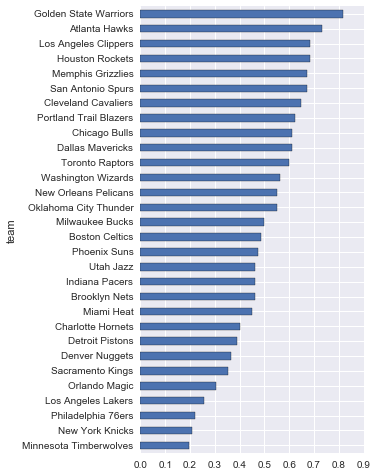

In [22]:
strength.sort_values().plot.barh(figsize=(4,8))

Bring the `strength` values in for each team, for each game.

For SQL people

```sql
SELECT *
FROM games NATURAL JOIN strength
```

We just need to get the names worked out.

In [23]:
(strength
         .head()
         .reset_index()
         .rename(columns=lambda x: 'away_' + x)
 )

,away_team,away_strength
0,Atlanta Hawks,0.731707
1,Boston Celtics,0.487805
2,Brooklyn Nets,0.463415
3,Charlotte Hornets,0.402439
4,Chicago Bulls,0.609756


In [24]:
(pd.merge(games.reset_index(), 
          strength.reset_index().add_prefix('away_'))
   .pipe(pd.merge, 
         strength.reset_index().add_prefix('home_'))
   .set_index(['game_id', 'date'])
)

,,away_team,away_points,home_team,...,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28 22:30:00,Houston Rockets,108.0,Los Angeles Lakers,...,False,0.682927,0.256098
664,2015-01-25 21:30:00,Houston Rockets,99.0,Los Angeles Lakers,...,False,0.682927,0.256098
544,2015-01-09 22:30:00,Orlando Magic,84.0,Los Angeles Lakers,...,True,0.304878,0.256098
...,...,...,...,...,...,...,...,...
478,2014-12-31 19:00:00,Charlotte Hornets,83.0,Houston Rockets,...,True,0.402439,0.682927
382,2014-12-18 20:30:00,New Orleans Pelicans,99.0,Houston Rockets,...,False,0.548780,0.682927
1201,2015-04-12 19:00:00,New Orleans Pelicans,114.0,Houston Rockets,...,True,0.548780,0.682927


For python people

In [25]:
games = games.assign(away_strength=games.away_team.map(strength),
                     home_strength=games.home_team.map(strength))
games

,,away_team,away_points,home_team,...,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28 22:30:00,Houston Rockets,108.0,Los Angeles Lakers,...,False,0.682927,0.256098
1,2014-10-28 20:00:00,Orlando Magic,84.0,New Orleans Pelicans,...,True,0.304878,0.548780
2,2014-10-28 20:00:00,Dallas Mavericks,100.0,San Antonio Spurs,...,True,0.609756,0.670732
...,...,...,...,...,...,...,...,...
1233,2015-04-15 20:00:00,Detroit Pistons,112.0,New York Knicks,...,False,0.390244,0.207317
1234,2015-04-15 20:00:00,Miami Heat,105.0,Philadelphia 76ers,...,False,0.451220,0.219512
1235,2015-04-15 19:00:00,Charlotte Hornets,87.0,Toronto Raptors,...,True,0.402439,0.597561


# Pivoting

In [26]:
tidy

,game_id,date,variable,team,rest
0,0,2014-10-28 22:30:00,away_team,Houston Rockets,NaN
1,1,2014-10-28 20:00:00,away_team,Orlando Magic,NaN
2,2,2014-10-28 20:00:00,away_team,Dallas Mavericks,NaN
...,...,...,...,...,...
2469,1233,2015-04-15 20:00:00,home_team,New York Knicks,1.0
2470,1234,2015-04-15 20:00:00,home_team,Philadelphia 76ers,1.0
2471,1235,2015-04-15 19:00:00,home_team,Toronto Raptors,-1.0


In [27]:
# summarizing pivot

un = (pd.pivot_table(tidy,
                     values='rest',
                     index='variable',
                     columns='team')
)
un

team,Atlanta Hawks,Boston Celtics,Brooklyn Nets,...,Toronto Raptors,Utah Jazz,Washington Wizards
variable,,,,,,,
away_team,0.500000,0.634146,0.750000,...,0.707317,0.463415,0.400000
home_team,1.097561,0.775000,0.707317,...,0.800000,1.100000,1.097561


In [28]:
# equivalent
tidy.groupby(['team','variable']).rest.mean().unstack('team')

team,Atlanta Hawks,Boston Celtics,Brooklyn Nets,...,Toronto Raptors,Utah Jazz,Washington Wizards
variable,,,,,,,
away_team,0.500000,0.634146,0.750000,...,0.707317,0.463415,0.400000
home_team,1.097561,0.775000,0.707317,...,0.800000,1.100000,1.097561


In [29]:
# transformational pivot

un = (pd.pivot_table(tidy,
                     values='rest',
                     index=['game_id','date'],
                     columns='variable',
                     aggfunc='mean')
        .rename(columns={'away_team': 'away_rest', 'home_team': 'home_rest'})
)
un.columns.name = None

In [30]:
un.dropna()

,,away_rest,home_rest
game_id,date,,
16,2014-10-30 20:30:00,-1.0,1.0
18,2014-10-30 20:00:00,-1.0,0.0
19,2014-10-30 19:00:00,-1.0,0.0
...,...,...,...
1233,2015-04-15 20:00:00,1.0,1.0
1234,2015-04-15 20:00:00,1.0,1.0
1235,2015-04-15 19:00:00,1.0,-1.0


In [31]:
# glue
res = pd.concat([games, un], axis=1).reset_index('date')
res

,date,away_team,away_points,...,home_strength,away_rest,home_rest
game_id,,,,,,,
0,2014-10-28 22:30:00,Houston Rockets,108.0,...,0.256098,NaN,NaN
1,2014-10-28 20:00:00,Orlando Magic,84.0,...,0.548780,NaN,NaN
2,2014-10-28 20:00:00,Dallas Mavericks,100.0,...,0.670732,NaN,NaN
...,...,...,...,...,...,...,...
1233,2015-04-15 20:00:00,Detroit Pistons,112.0,...,0.207317,1.0,1.0
1234,2015-04-15 20:00:00,Miami Heat,105.0,...,0.219512,1.0,1.0
1235,2015-04-15 19:00:00,Charlotte Hornets,87.0,...,0.597561,1.0,-1.0


In [32]:
res.to_hdf('data/games.hdf','df',mode='w',format='table')